# CLEAN BUILD FROM SCRATCH mitb2 on patches

In [1]:
CURRENT_FOLD = 3

In [2]:
!nvidia-smi

Thu Sep  1 09:12:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0    55W / 300W |   1708MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   45C    P0    54W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# imports

In [3]:
import random

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.cuda.amp as amp
is_amp = True

In [4]:
torch.multiprocessing.set_start_method('spawn')

# data

In [5]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [6]:
from coat import *
from daformer import *
from torch.optim.swa_utils import AveragedModel, SWALR

## data 512

In [7]:
# img256 = cv.imread('./../data/train_data_eunet_patches/256/train/10044_0000.png')
# img512 = cv.imread('./../data/train_data_eunet_patches/512/train/10044_0000.png')

In [8]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_patches_768_overlap/'
TRAIN_MASKS_DIR = './../data/train_masks_patches_768_overlap/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 768 # размер патча


In [9]:
train_df = pd.read_csv(TRAIN_CSV)

In [10]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [11]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [12]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [13]:
def make_768_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('_images_', '_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [14]:
train_df_768 = make_768_dataset(train_df)
print(train_df_768.shape)
train_df_768.head()

(8658, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
1,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
2,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
3,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4
4,4.0,10044,./../data/train_images_patches_768_overlap/100...,./../data/train_masks_patches_768_overlap/1004...,prostate,0.4


In [15]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [16]:
# mean = np.array([0.7720342, 0.74582646, 0.76392896])
# std = np.array([0.24745085, 0.26182273, 0.25782376])

In [17]:
def pad_to(x, stride):
    h, w = x.shape[-2:]

    if h % stride > 0:
        new_h = h + stride - h % stride
    else:
        new_h = h
    if w % stride > 0:
        new_w = w + stride - w % stride
    else:
        new_w = w
    lh, uh = int((new_h-h) / 2), int(new_h-h) - int((new_h-h) / 2)
    lw, uw = int((new_w-w) / 2), int(new_w-w) - int((new_w-w) / 2)
    pads = (lw, uw, lh, uh)

    # zero-padding by default.
    # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
    out = F.pad(x, pads, "constant", 0)

    return out, pads

def unpad(x, pad):
    if pad[2]+pad[3] > 0:
        x = x[:,:,pad[2]:-pad[3],:]
    if pad[0]+pad[1] > 0:
        x = x[:,:,:,pad[0]:-pad[1]]
    return x

In [18]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(0.05, 0.6),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [19]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [20]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        print(index)
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        mask = cv.imread(d['mask'], cv.IMREAD_GRAYSCALE)

        mask = mask / max(1, mask.max())
        
        mask_multiclass = mask * (organ + 1)
        
        data = {
            'image': image,
            'mask': mask_multiclass,
            'organ': organ,
        }
        
        upd_data = self.transform(image=data['image'], mask=data['mask'])
        upd_data['image'] = upd_data['image'].to('cuda:2')

        data.update(upd_data)
        return data

In [21]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

In [22]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], train_transform)
val_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] == CURRENT_FOLD], val_transform)

1
IMAGE
torch.Size([3, 768, 768])
image values:  0.0 0.960784375667572


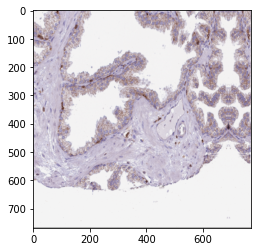

MASK
torch.Size([768, 768])
mask values:  tensor(0., dtype=torch.float64) tensor(2., dtype=torch.float64)


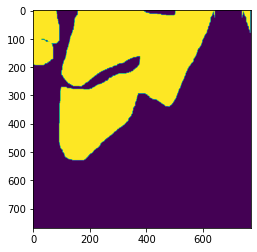

In [23]:
sample = train_dataset[1]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].detach().cpu().permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

In [24]:
BATCH_SIZE = 4

In [25]:
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          worker_init_fn=worker_init_fn,
                          num_workers=0
                         )
loader_val = DataLoader(val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        worker_init_fn=worker_init_fn,
                        num_workers=0
                       )

2
IMAGE
torch.Size([3, 768, 768])
image values:  0.027450982481241226 1.0


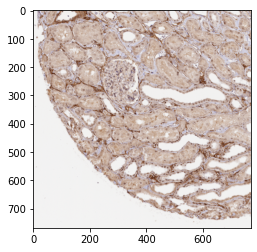

MASK
torch.Size([768, 768])
mask values:  tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)


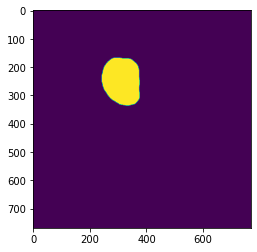

In [26]:
sample = val_dataset[2]
print('IMAGE')
print(sample['image'].shape)
print('image values: ', float(sample['image'].min()), float(sample['image'].max()))
plt.imshow(sample['image'].detach().cpu().permute((1, 2, 0)))
plt.show()

print('MASK')
print(sample['mask'].shape)
print('mask values: ', sample['mask'].min(), sample['mask'].max())
plt.imshow(sample['mask'])
plt.show()

# model

In [27]:
from model_coat_daformer import *

In [28]:
device = 'cuda:1'
DEVICE = device

In [29]:
encoder = coat_parallel_small
decoder = daformer_conv3x3

model = Net(encoder=encoder, decoder=decoder, n_classes=6).to(device)

In [30]:
swa_model = AveragedModel(model).to(device)

In [73]:
swa_model.load_state_dict(torch.load('./checkpoint_fold_3/coat-small-v2-fold3_TOP_7_BEST_SCALED.pt', map_location=device))

<All keys matched successfully>

In [74]:
# model.load_state_dict(torch.load('./checkpoint_fold_3/coat-small_ep_095_dice_0.608668.pt', map_location=device))
# model = model.eval()

In [75]:
# torch.optim.swa_utils.update_bn(loader_train, swa_model)

In [76]:
model = swa_model.eval()

In [77]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

31852122

# validation code

In [78]:
import monai
from monai.utils.enums import BlendMode, PytorchPadMode
from monai.inferers import sliding_window_inference

In [79]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union < 1: 
        return 1
    intersection = np.sum(y_true_f * y_pred_f)
#     print('UNION', union)
    return 2. * intersection / union

In [80]:
class Predictor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, data):
        out = self.model(data)
        prob = F.softmax(out['logits'], dim=1)
        return prob

In [81]:
# def infer_id_monai(predictor, id: str, organ: str, pixel_size=0.4, threshold=0.5):
#     THRESHOLD = threshold
    
#     image = cv.imread('./../data/train_images_768/{}.png'.format(id))
#     image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
#     gt_mask  = np.load('./../data/train_masks_768/{}.npy'.format(id))
    
#     scale_factor = 1.0#0.25 * (pixel_size / 0.4)
#     image1 = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
# #     image2 = cv.resize(image, None, fx=scale_factor*1.2, fy=scale_factor*1.3, interpolation=cv.INTER_AREA)
    
    
# #     image_rot = image.copy()
#     masks = []
#     for cur_image in [image1]:
#         for img_flip in [None, 0, 1]:#, -1]:
#             if img_flip is not None:
#                 image = cv.flip(image1, img_flip)
#             else:
#                 image = image1.copy()

#             image_tensor = val_transform(image=image)['image']

#             image_tensor = image_tensor.unsqueeze(0).to(device)

#             with torch.no_grad():
#                 image_tensor, pads = pad_to(image_tensor, 32)
#                 infer_result = predictor(image_tensor)
#     #             infer_result = sliding_window_inference(
#     #                 image_tensor, roi_size=(768, 768), sw_batch_size=2, predictor=predictor, 
#     #                 overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
#     #                 padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
#     #             )
#                 infer_result = unpad(infer_result, pads)

#             organ_id = ORGAN2ID[organ] + 1
#             pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
#     #         pr_mask = infer_result.detach().cpu().numpy()[0, 1:].sum(axis=1)
#             if img_flip is not None:
#                 pr_mask = cv.flip(pr_mask, img_flip)
#             masks.append(pr_mask)
    
#     masks = [cv.resize(x, gt_mask.shape, cv.INTER_NEAREST) for x in masks]
# #     pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
#     pr_mask = np.array(masks).mean(axis=0)
    
# #     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)

#     return pr_mask, gt_mask

In [82]:
def infer_id_monai(predictor, id: str, organ: str, pixel_size=0.4, threshold=0.5):
    THRESHOLD = threshold
    
    image = cv.imread('./../data/train_images/{}.tiff'.format(id))
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    
    gt_mask  = np.load('./../data/train_masks/{}.npy'.format(id))
    
    scale_factor = 0.25 * (pixel_size / 0.4)
    image1 = cv.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv.INTER_AREA)
#     image2 = cv.resize(image, None, fx=scale_factor*1.2, fy=scale_factor*1.3, interpolation=cv.INTER_AREA)
    
    
#     image_rot = image.copy()
    masks = []
    for cur_image in [image1]:
        for img_flip in [None, 0, 1]:#, -1]:
            if img_flip is not None:
                image = cv.flip(image1, img_flip)
            else:
                image = image1.copy()

            image_tensor = val_transform(image=image)['image']

            image_tensor = image_tensor.unsqueeze(0).to(device)

            with torch.no_grad():
                image_tensor, pads = pad_to(image_tensor, 32)
                infer_result = predictor({'image': image_tensor, 'organ': [ORGAN2ID[organ]]})
    #             infer_result = sliding_window_inference(
    #                 image_tensor, roi_size=(768, 768), sw_batch_size=2, predictor=predictor, 
    #                 overlap=0.25, mode=BlendMode.CONSTANT, sigma_scale=0.125, 
    #                 padding_mode=PytorchPadMode.CONSTANT, cval=0.0,       
    #             )
                infer_result = unpad(infer_result, pads)

            organ_id = ORGAN2ID[organ] + 1
            pr_mask = infer_result.detach().cpu().numpy()[0, organ_id]
    #         pr_mask = infer_result.detach().cpu().numpy()[0, 1:].sum(axis=1)
            if img_flip is not None:
                pr_mask = cv.flip(pr_mask, img_flip)
            masks.append(pr_mask)
    
    masks = [cv.resize(x, gt_mask.shape, cv.INTER_NEAREST) for x in masks]
#     pr_mask = (np.array(masks).mean(axis=0) > THRESHOLD).astype(np.uint8)
    pr_mask = np.array(masks).mean(axis=0)
    
#     print(gt_mask.shape, gt_mask.dtype, pr_mask.dtype)

    return pr_mask, gt_mask

In [83]:
def check_dice_by_thresh(val_df, model, th, infer_id_function):
    predictor = Predictor(model)
    
    dices = []
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        pred_mask, gt_mask = infer_id_function(predictor, id, organ=organ, pixel_size=pixel_size, threshold=th)
    
        pred_mask = (pred_mask > th).astype(np.uint8)
        dice = dice_coef2(gt_mask, pred_mask)
        dices.append(dice)
    return np.mean(dices)

In [84]:
val_df_id = train_df[train_df['fold'] == CURRENT_FOLD]

In [85]:
check_dice_by_thresh(val_df_id, model, th=0.5, infer_id_function=infer_id_monai)

100%|██████████| 70/70 [00:45<00:00,  1.54it/s]


0.7714824630023432

In [131]:
check_dice_by_thresh(val_df_id, model, th=0.5, infer_id_function=infer_id_monai)

100%|██████████| 70/70 [00:47<00:00,  1.48it/s]


0.7726010581440618

In [112]:
# mpmp = dict()
# for fname in list(sorted(glob('./checkpoint_fold_3/*.pt'))):
#     print(fname)
#     model.load_state_dict(torch.load(fname, map_location=device))
#     model = model.eval()
#     mpmp[fname] = check_dice_by_thresh(val_df_id, model, th=0.5, infer_id_function=infer_id_monai)
# #     break

In [126]:
# for key, value in mpmp.items():
#     print(key, value)
#     new_fname = '{}_{:7.6f}.pt'.format(key.rsplit('_', maxsplit=1)[0], value)
#     print(new_fname)
#     os.rename(key, new_fname)

# thresholds

In [86]:
def precalc_preds(val_df, model, th, infer_id_function):
    predictor = Predictor(model)
    
    organ2mask = dict()
    for index, row in tqdm(val_df.iterrows(), total=len(val_df)):
        id = row['id']
        organ = row['organ']
        pixel_size = row['pixel_size']
        if organ not in organ2mask:
            organ2mask[organ] = []
            
        pred_mask, gt_mask = infer_id_function(predictor, id, organ=organ, pixel_size=pixel_size, threshold=th)
        organ2mask[organ].append({'id': id, 'organ': organ, 'pred': pred_mask, 'gt': gt_mask})
    return organ2mask

In [87]:
organ2mask = precalc_preds(val_df_id, model, th=0.5, infer_id_function=infer_id_monai)

100%|██████████| 70/70 [03:21<00:00,  2.88s/it]


In [88]:
organ2mask.keys()

dict_keys(['kidney', 'spleen', 'prostate', 'lung', 'largeintestine'])

In [89]:
organ2mask['kidney'][0]['pred'].max()

0.9999997

In [90]:
len(organ2mask)

5

In [91]:
def try_threshold_for_organ(organ):
    ths = []
    scores = []
    for th in tqdm(np.linspace(0, 1.0, 51)):
#         print(th)
        dices = []
        for el in organ2mask[organ]:
            dice = dice_coef2(el['gt'], (el['pred'] > th).astype(np.uint8))
            dices.append(dice)
        ths.append(th)
        scores.append(np.mean(dices))
    return ths, scores

In [92]:
saved_data = dict()
for organ in ORGAN2ID.keys():
    print(organ)
    ths, scores = try_threshold_for_organ(organ)
    saved_data[organ] = ths, scores

kidney


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


prostate


100%|██████████| 51/51 [00:49<00:00,  1.04it/s]


largeintestine


100%|██████████| 51/51 [00:36<00:00,  1.38it/s]


spleen


100%|██████████| 51/51 [00:33<00:00,  1.54it/s]


lung


100%|██████████| 51/51 [00:30<00:00,  1.66it/s]


In [93]:
for key in saved_data.keys():
    argmax_index = np.argmax(saved_data[key][1])
    argmax_value = saved_data[key][0][argmax_index]
    print('{:16} {:7.6f}'.format(key, saved_data[key][1][argmax_index]))

kidney           0.942998
prostate         0.839808
largeintestine   0.895540
spleen           0.701419
lung             0.276169


In [95]:
ORG2TH = {
    'kidney': 0.70,
    'prostate': 0.24,
    'largeintestine': 0.46,
    'spleen': 0.90,
    'lung': 0.32
}

In [96]:
dices = []
for organ in ORGAN2ID.keys():
    for el in organ2mask[organ]:
        dice = dice_coef2(el['gt'], (el['pred'] > ORG2TH[organ]).astype(np.uint8))
        dices.append(dice)
#     dices.append()

In [97]:
np.mean(dices)

0.7751039102607606

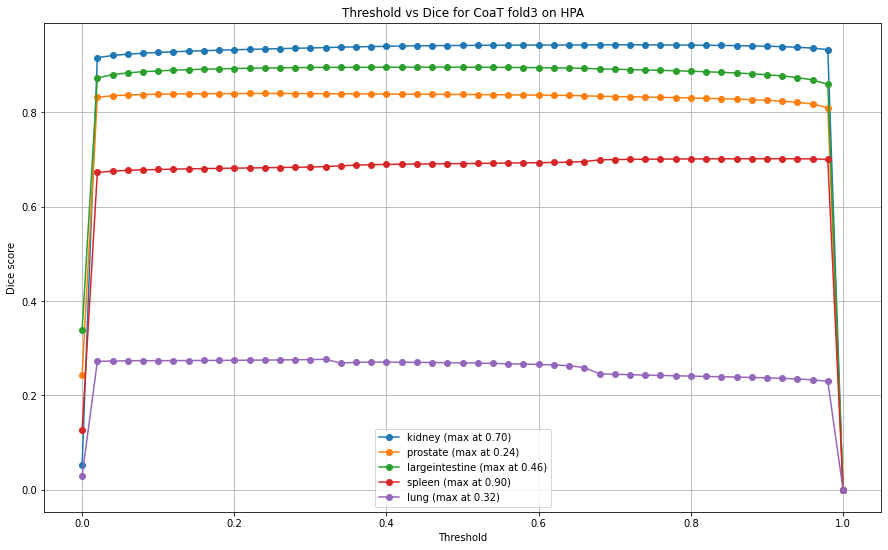

In [94]:
plt.figure(figsize=(15, 9))
for key in saved_data.keys():
    argmax_index = np.argmax(saved_data[key][1])
    argmax_value = saved_data[key][0][argmax_index]
    
    plt.plot(saved_data[key][0], saved_data[key][1], marker='o', 
             label='{} (max at {:03.2f})'.format(key, argmax_value))
    
plt.grid()
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Dice score')
plt.title('Threshold vs Dice for CoaT fold3 on HPA')
plt.show()

# lung dilation-erosion

In [92]:
lung_df = val_df_id[val_df_id['organ'] == 'lung']

In [189]:
check_dice_by_thresh(lung_df, model, th=0.15, infer_id_function=infer_id_monai)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 10/10 [00:54<00:00,  5.49s/it]


0.2861158972186218

In [211]:
def make_reverse_mask(img):
    blur = cv.GaussianBlur(img, (5,5), 0)
    ret3, th3 = cv.threshold(blur.mean(axis=2).astype(np.uint8), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    dilatation_size = 2
    element = cv.getStructuringElement(cv.MORPH_RECT, (2 * dilatation_size + 1, 2 * dilatation_size + 1),
                                       (dilatation_size, dilatation_size))
    dilated = cv.dilate(255 - th3, element)
    ffilled = cv.floodFill(dilated.copy(), None, (0, 0), newVal=255)[1]
    
    resid_mask = ffilled.astype(np.float32) - dilated.astype(np.float32)
    resid_mask = (resid_mask > 128).astype(np.uint8)
    return resid_mask

In [218]:
dices = []
for el in tqdm(organ2mask[organ]):
    orig_img = cv.imread('./../data/train_images/{}.tiff'.format(el['id']))
    orig_img = cv.cvtColor(orig_img, cv.COLOR_BGR2RGB)
    res_mask =  make_mask(orig_img)
    dice = dice_coef2(el['gt'], ((el['pred'] > 0.1) & (~res_mask)).astype(np.uint8))
    dices.append(dice)

100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


In [219]:
np.mean(dices)

0.30123704248624905

# looking where can be a problem

In [226]:
!mkdir fold3images

In [230]:
for key in organ2mask.keys():
    print(key)
    for el in organ2mask[key]:
        img = cv.imread('./../data/train_images/{}.tiff'.format(el['id']))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        fig, axs = plt.subplots(1, 3, figsize=(21, 8))
        fig.suptitle(str(el['id']))
        axs[0].imshow(img)
        axs[1].imshow(el['pred'])
        axs[2].imshow(el['gt'])
        print('saving fig...')
        fig.savefig('./fold3images/{}_{}.png'.format(key, el['id']))
        plt.close()
#         0/0

kidney
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
spleen
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
prostate
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
lung
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
largeintestine
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
saving fig...
savin

In [231]:
!tar -czvf fold3images.tar.gz ./fold3images/

./fold3images/
./fold3images/prostate_29213.png
./fold3images/kidney_1157.png
./fold3images/kidney_25620.png
./fold3images/largeintestine_8450.png
./fold3images/prostate_1229.png
./fold3images/largeintestine_13507.png
./fold3images/largeintestine_26319.png
./fold3images/kidney_16362.png
./fold3images/largeintestine_13396.png
./fold3images/spleen_3057.png
./fold3images/largeintestine_16728.png
./fold3images/prostate_27471.png
./fold3images/kidney_23243.png
./fold3images/kidney_23051.png
./fold3images/prostate_18422.png
./fold3images/prostate_30355.png
./fold3images/kidney_24222.png
./fold3images/prostate_5317.png
./fold3images/kidney_6021.png
./fold3images/kidney_2500.png
./fold3images/prostate_1955.png
./fold3images/spleen_25472.png
./fold3images/lung_5552.png
./fold3images/prostate_28622.png
./fold3images/prostate_25430.png
./fold3images/kidney_4777.png
./fold3images/spleen_11645.png
./fold3images/lung_28189.png
./fold3images/spleen_29143.png
./fold3images/kidney_28940.png
./fold3imag

# custom inference (no MONAI)

In [ ]:
291 = 210 (hubmap) + 81 (hpa)

In [ ]:
0.77 = 0.55 (hubmap) + 0.22

In [ ]:
HuBMAP normalized = 0.55

In [245]:
0.55 * (291 / 210)

0.7621428571428572

In [246]:
0.22 * (291 / 81)

0.7903703703703704

# plot scores

In [77]:
from glob import glob
import os

In [78]:
xs = []
ys = []
for fname in list(sorted(glob('./checkpoint_fold_3/*.pt'))):
    bname = os.path.basename(fname)
    spt = bname.split('_')
    ep = int(spt[2])
    dice = float(spt[4].rsplit('.', maxsplit=1)[0])
    xs.append(ep)
    ys.append(dice)

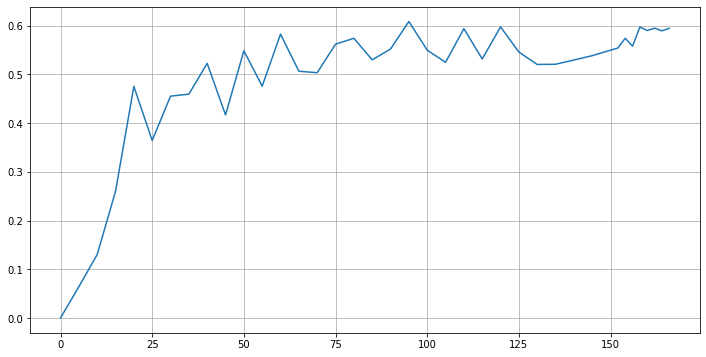

In [79]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys)
plt.grid()
plt.show()